In [1]:
import sys
sys.path.append('..')
from utils.dataloader_jetnet import PointCloudDataloader
from utils.helpers import plotting_thesis
from utils.helpers import mass
from fit.fit_nf import NF


/gpfs/dust/maxwell/user/kaechben/.conda/envs/mdma-cfm/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/gpfs/dust/maxwell/user/kaechben/.conda/envs/mdma-cfm/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/late

In [6]:
model=NF.load_from_checkpoint("../ckpts/t_ccnf_new.ckpt")
dm=PointCloudDataloader(batch_size=1024,n_part=30,n_dim=3,parton="t",sampler=False)
dm.setup("fit")


In [7]:
import torch
fakes=[]
real=[]
model.n_part=dm.n_part
model.n_dim=dm.n_dim
model.scaler=dm.scaler.to("cuda")
model.scaled_mins=torch.ones(4).cuda()*(-1000)
model.scaled_maxs=torch.ones(4).cuda()*(1000)
model.mins=torch.ones(4).cuda()*(-1000)
model.maxs=torch.ones(4).cuda()*(1000)
model=model.cuda()
masks=[]
model.train()
for data in dm.val_dataloader():

    with torch.no_grad():
        data,mask,_=data
        data=data.cuda()
        mask=mask.cuda()
        # data=dm.scaler.inverse_transform(data.reshape(-1,dm.n_part,dm.n_dim))
        m=mass(data).reshape(-1)
        fake=model.sampleandscale(data,mask,m,scale=True)[0]
        real.append(data)
        # fakes.append(data)
        fakes.append(fake.detach().cpu())
        masks.append(mask)
masks=torch.cat(masks).cpu()
real=torch.cat(real).cpu()
fake=torch.cat(fakes).cpu()


(0.0008686800890602137, 4.619460299916231e-05)


/home/kaechben/MDMACalo/notebooks/../utils/helpers.py:326: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.3)


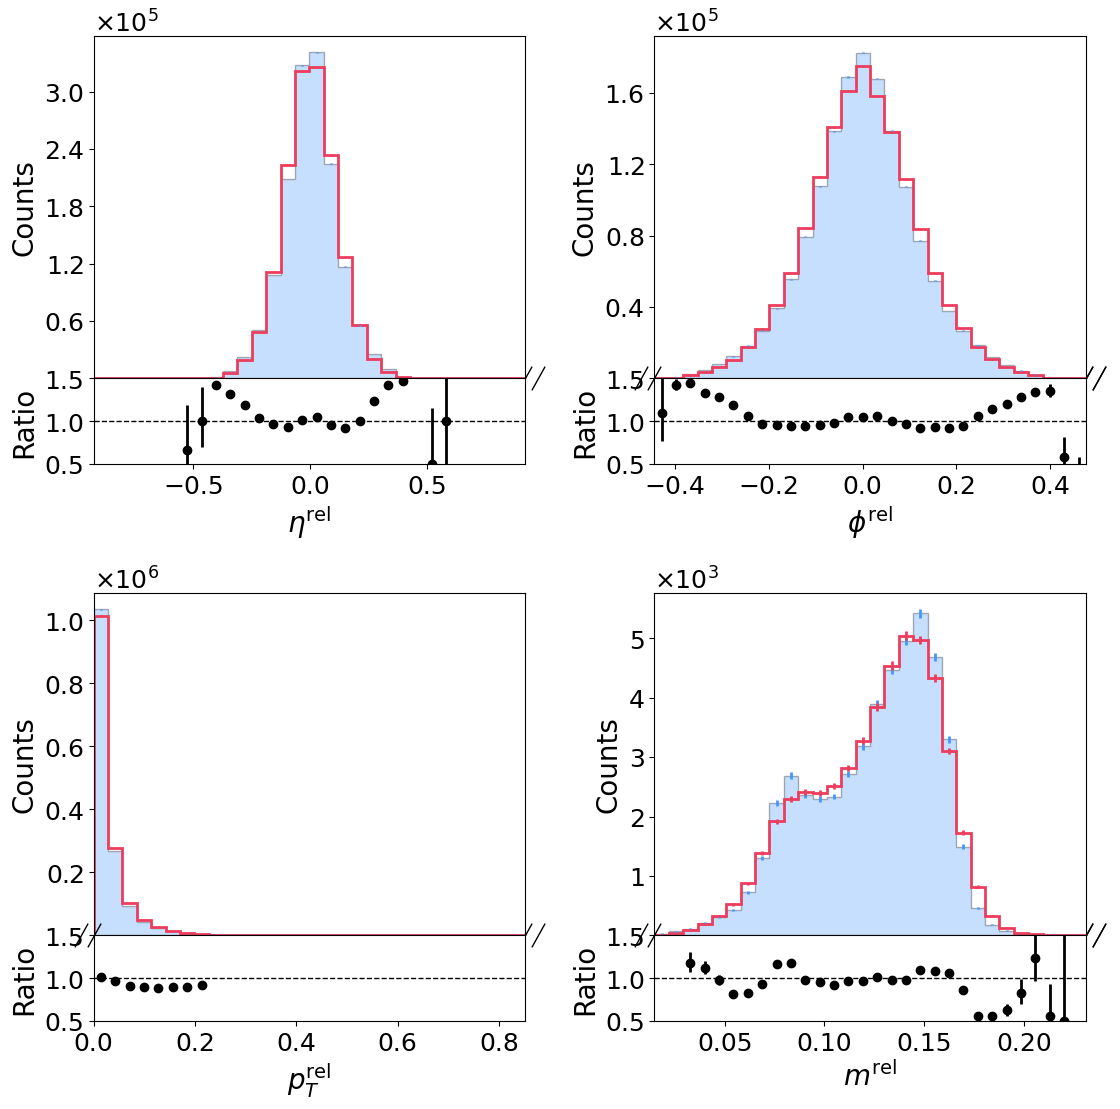

In [8]:
from utils.helpers import plotting_thesis, get_hists
from jetnet.evaluation import w1m
print(w1m(real,fake))
mins=torch.cat((real.reshape(-1,3).min(0)[0],torch.tensor(mass(real).reshape(-1).min().item()).reshape(1)))
maxs=torch.cat((real.reshape(-1,3).max(0)[0],torch.tensor(mass(real).reshape(-1).max().item()).reshape(1)))

hists=get_hists([30,30,30,30],mins,maxs,calo=False)
hist_real=hists["hists_real"]
hist_fake=hists["hists_fake"]
for i in range(3):
    hist_fake[i].fill(fake.cpu().numpy().reshape(-1,3)[:,i])
    hist_real[i].fill(real.cpu().numpy().reshape(-1,3)[:,i],)
hist_fake[3].fill(mass(fake).cpu().numpy().reshape(-1))
hist_real[3].fill(mass(real).cpu().numpy().reshape(-1))
plot=plotting_thesis()
plot.plot_ratio(h_fake=hist_fake,h_real=hist_real,weighted=False)

/home/kaechben/MDMACalo/notebooks/../utils/helpers.py:326: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.3)


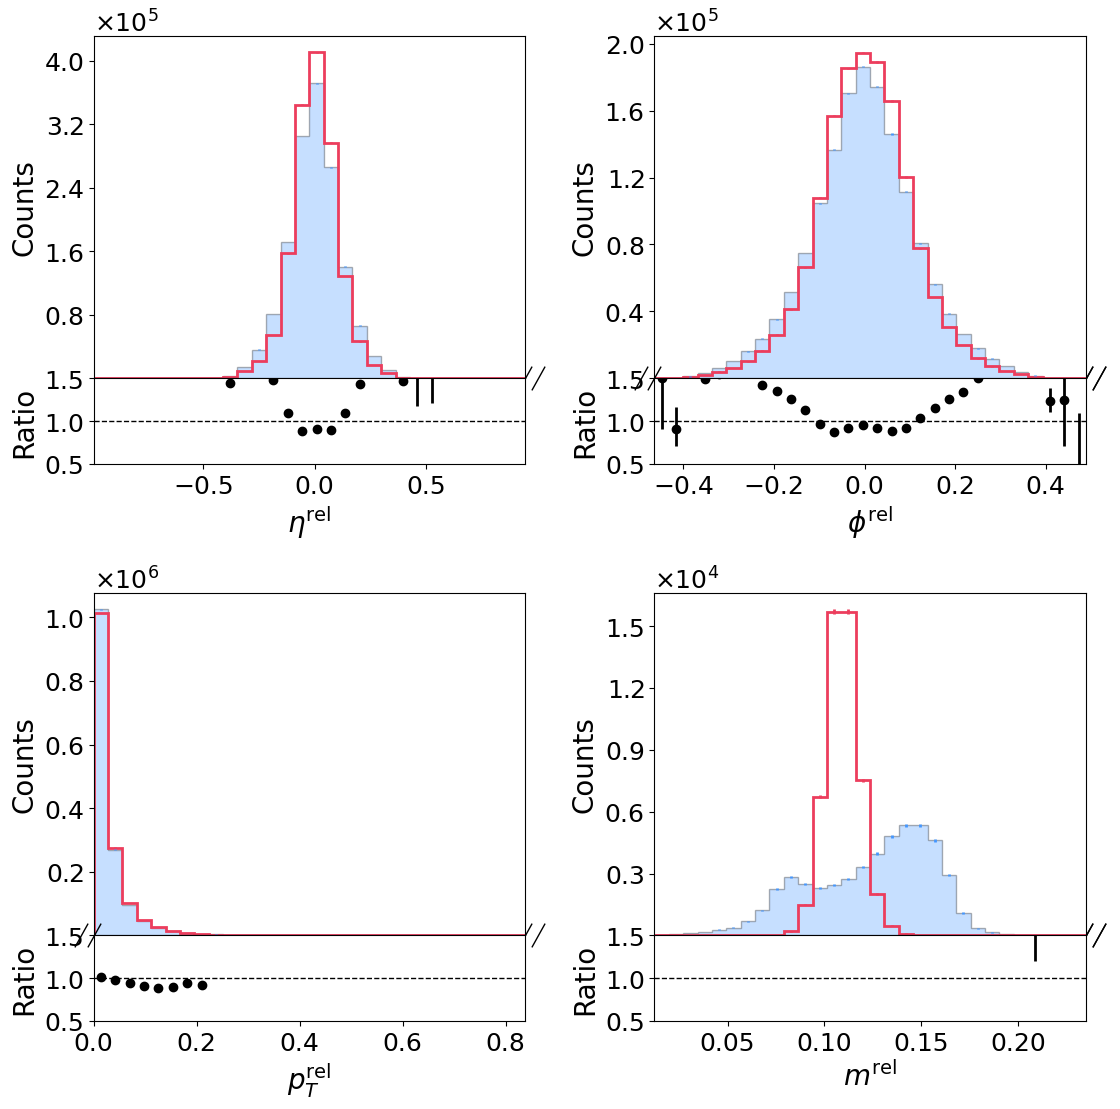

In [11]:
real=[]
fakes=[]
masks=[]
model=model.cuda()
for data in dm.test_dataloader():
    with torch.no_grad():
        data,mask,_=data
        data=data.cuda()
        mask=mask.cuda()
        m=0.05*torch.ones_like(mass(data).reshape(-1))
        fake=model.sampleandscale(data,mask,m,scale=True)[0]
        real.append(data)
        # fakes.append(data)
        fakes.append(fake.detach().cpu())
        masks.append(mask)
real=torch.cat(real).cpu()
fake=torch.cat(fakes).cpu()
masks=torch.cat(masks).cpu()
mins=torch.cat((real.reshape(-1,3).min(0)[0],torch.tensor(mass(real).reshape(-1).min().item()).reshape(1)))
maxs=torch.cat((real.reshape(-1,3).max(0)[0],torch.tensor(mass(real).reshape(-1).max().item()).reshape(1)))

hists=get_hists([30,30,30,30],mins,maxs,calo=False)
hist_real=hists["hists_real"]
hist_fake=hists["hists_fake"]
for i in range(3):
    hist_fake[i].fill(fake[~masks].cpu().numpy().reshape(-1,3)[:,i])
    hist_real[i].fill(real[~masks].cpu().numpy().reshape(-1,3)[:,i],)
hist_fake[3].fill(mass(fake).cpu().numpy().reshape(-1))
hist_real[3].fill(mass(real).cpu().numpy().reshape(-1))
plot=plotting_thesis()
plot.plot_ratio(h_fake=hist_fake,h_real=hist_real,weighted=False)

In [ ]:
from
i=0
for k in samples.keys():
    if k=="true":
        continue
    fake=samples[k]
    fig,ax=plt.subplots(1,3,figsize=plot.fig_size3)

    for i in range(3):
        true=samples["true"].reshape(-1,30,3).clone()

        m_up=float(k.split("=")[-1].split("$")[0])+0.02
        true=true[mass(true[:,:,:])<m_up]
        m_down=float(k.split("=")[-1].split("$")[0])-0.02
        true=true[mass(true[:,:,:])>m_down]

        _,b,_=ax[i].hist(true.reshape(-1,3)[:,i].numpy(),bins=30,alpha=0.3,label="Ground Truth ${:.2f}< m^{}<{:.2f}$".format(m_down,"{rel}",m_up),color=plot.cmap[1],density=1)
        ax[i].set_ylabel("Counts (Normalised)")
        # ax2 =ax[i].twinx()
        ax[i].ticklabel_format(axis="y", style="scientific", scilimits=(-3, 3), useMathText=True)
        # ax2.ticklabel_format(axis="y", style="scientific", scilimits=(-3, 3), useMathText=True)
        ax[i].hist(fake.reshape(-1,3)[:,i].numpy(),bins=b,alpha=1,label="Generated",histtype="step",lw=4,density=1)
        # ax2.set_ylabel("Counts Generated")
        handles = [mpatches.Patch(color=sns.color_palette()[z], label=label)  for z, label in enumerate(["Ground Truth ${:.2f}< m^{}<{:.2f}$".format(m_down,"{rel}",m_up),"Generated "+k])]
        ax[-1].legend(handles=handles, fontsize=15,loc="upper right")
        ax[i].set_xlabel(["$\eta^{rel}$","$\phi^{rel}$","$p_T^{rel}$"][i])
    # plt.suptitle("Particle Feature Distribution for Different Mass Conditionings", fontsize=28, fontweight="bold")
    plt.tight_layout()
    plt.savefig("plots/feature_mass_conditioning_{}.pdf".format(k.split("=")[-1].split("$")[0]),format="pdf")
    plt.show()